In this notebook I will try and predict what kind of an incident occured based on where it took place and how long it took to resolve. 

Target: issue_reported(y)
Input vairables: Latitude, Longitude, timespan_min(x)


In [213]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score,log_loss, f1_score, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn import model_selection
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb

Import data of clean features

In [214]:
file = 'traffic_data_features.csv'

In [215]:
df = pd.read_csv(file, index_col=False)
df.head()

,issue_reported,Latitude,Longitude,day,timespan_min,hour,month,region,dist_from_center
0,Crash Service,30.283797,-97.741906,2,144.066667,6,6,cnw,1.849061
1,Traffic Hazard,30.339593,-97.700963,2,64.450000,10,6,vne,9.009002
2,Crash Service,30.329455,-97.638105,4,30.000000,21,4,vce,12.228301
3,Traffic Hazard,30.202806,-97.760701,4,14.183333,21,4,vsw,7.357232
4,Crash Service,30.184265,-97.687339,4,149.150000,21,4,vse,10.665180


In [216]:
df.describe()

,Latitude,Longitude,day,timespan_min,hour,month,dist_from_center
count,225445.000000,225445.000000,225445.000000,225445.000000,225445.000000,225445.000000,225445.000000
mean,30.301440,-97.733156,2.906261,49.665617,13.693637,6.980594,11.891963
std,0.094080,0.087511,1.935056,39.684226,7.140035,3.388540,7.349437
min,30.003883,-98.226709,0.000000,0.333333,0.000000,1.000000,0.007638
25%,30.231715,-97.777183,1.000000,19.500000,9.000000,4.000000,6.060222
50%,30.293602,-97.734450,3.000000,37.500000,15.000000,7.000000,11.071200
75%,30.373691,-97.686922,5.000000,68.516667,20.000000,10.000000,16.999669
max,30.798642,-97.293320,6.000000,200.000000,23.000000,12.000000,60.669983


In [217]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 225445 entries, 0 to 225444
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   issue_reported    225445 non-null  object 
 1   Latitude          225445 non-null  float64
 2   Longitude         225445 non-null  float64
 3   day               225445 non-null  int64  
 4   timespan_min      225445 non-null  float64
 5   hour              225445 non-null  int64  
 6   month             225445 non-null  int64  
 7   region            225445 non-null  object 
 8   dist_from_center  225445 non-null  float64
dtypes: float64(4), int64(3), object(2)
memory usage: 15.5+ MB


#  Use Label Encoder for categorical data we are trying to predict
Trying to predict the "issue_reported" involves transforming the column using LabelEncoder(). Then a quick check to ensure the numbers line up like before.

In [218]:
le = LabelEncoder()
df['issue_reported']=le.fit_transform(df['issue_reported'])
df.head()

,issue_reported,Latitude,Longitude,day,timespan_min,hour,month,region,dist_from_center
0,2,30.283797,-97.741906,2,144.066667,6,6,cnw,1.849061
1,5,30.339593,-97.700963,2,64.450000,10,6,vne,9.009002
2,2,30.329455,-97.638105,4,30.000000,21,4,vce,12.228301
3,5,30.202806,-97.760701,4,14.183333,21,4,vsw,7.357232
4,2,30.184265,-97.687339,4,149.150000,21,4,vse,10.665180


In [219]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 225445 entries, 0 to 225444
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   issue_reported    225445 non-null  int64  
 1   Latitude          225445 non-null  float64
 2   Longitude         225445 non-null  float64
 3   day               225445 non-null  int64  
 4   timespan_min      225445 non-null  float64
 5   hour              225445 non-null  int64  
 6   month             225445 non-null  int64  
 7   region            225445 non-null  object 
 8   dist_from_center  225445 non-null  float64
dtypes: float64(4), int64(4), object(1)
memory usage: 15.5+ MB


In [220]:
df['issue_reported'].unique()

array([2, 5, 1, 4, 0, 3, 6])

In [221]:
df['issue_reported'].value_counts()

5    92530
2    85024
0    25467
4    10818
3     5567
1     5286
6      753
Name: issue_reported, dtype: int64

In [222]:
avg_issue = df.groupby('issue_reported').mean()
avg_issue_span = avg_issue.timespan_min
avg_issue_span

issue_reported
0    42.979385
1    55.196339
2    68.461010
3    42.089731
4    31.433333
5    36.540976
6    45.440106
Name: timespan_min, dtype: float64

In [223]:
median_issue = df.groupby('issue_reported').median()
median_issue_span = median_issue.timespan_min
median_issue_span

issue_reported
0    36.016667
1    50.450000
2    60.466667
3    32.066667
4    22.775000
5    27.000000
6    31.833333
Name: timespan_min, dtype: float64

In [224]:
df['region'].value_counts()

vne    46522
vnw    34619
vcw    29815
vsw    28881
cne    16911
vse    13828
cw     13356
vce    13000
cnw     9623
csw     7660
cse     6366
ce      4864
Name: region, dtype: int64

## Apply LabelEncoder on the new categorical column 'region'.

In [225]:
le2 = LabelEncoder()
df['region']=le2.fit_transform(df['region'])
df.head()

,issue_reported,Latitude,Longitude,day,timespan_min,hour,month,region,dist_from_center
0,2,30.283797,-97.741906,2,144.066667,6,6,2,1.849061
1,5,30.339593,-97.700963,2,64.450000,10,6,8,9.009002
2,2,30.329455,-97.638105,4,30.000000,21,4,6,12.228301
3,5,30.202806,-97.760701,4,14.183333,21,4,11,7.357232
4,2,30.184265,-97.687339,4,149.150000,21,4,10,10.665180


### Drop "Latitude" and "Longitude"

In [226]:
df = df.drop(columns=['Latitude', 'Longitude'])
df.head()

,issue_reported,day,timespan_min,hour,month,region,dist_from_center
0,2,2,144.066667,6,6,2,1.849061
1,5,2,64.450000,10,6,8,9.009002
2,2,4,30.000000,21,4,6,12.228301
3,5,4,14.183333,21,4,11,7.357232
4,2,4,149.150000,21,4,10,10.665180


## Scaling Timespan Feature

In [227]:
series = df.timespan_min.values


In [228]:
series = series.reshape(-1,1)

In [229]:
scaler = StandardScaler()

In [230]:
scaled = scaler.fit_transform(series)

In [231]:
scaled

array([[ 2.37881063],
       [ 0.37255145],
       [-0.49555359],
       ...,
       [-1.13266792],
       [-1.11208875],
       [-1.14862728]])

In [233]:
df['scaled_timespan'] = scaled
df.head()

,issue_reported,day,timespan_min,hour,month,region,dist_from_center,scaled_timespan
0,2,2,144.066667,6,6,2,1.849061,2.378811
1,5,2,64.450000,10,6,8,9.009002,0.372551
2,2,4,30.000000,21,4,6,12.228301,-0.495554
3,5,4,14.183333,21,4,11,7.357232,-0.894118
4,2,4,149.150000,21,4,10,10.665180,2.506905


In [237]:
dummies = pd.get_dummies(df, columns=['day','hour','month','region'])

In [240]:
dummies = dummies.drop(columns=['issue_reported', 'timespan_min'])

In [241]:
dummies.head()

,dist_from_center,scaled_timespan,day_0,day_1,day_2,day_3,day_4,day_5,day_6,hour_0,...,region_2,region_3,region_4,region_5,region_6,region_7,region_8,region_9,region_10,region_11
0,1.849061,2.378811,0,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,9.009002,0.372551,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,12.228301,-0.495554,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,7.357232,-0.894118,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,10.665180,2.506905,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [111]:
X = dummies

In [112]:

y = df.issue_reported

In [113]:
X.shape

(225445, 56)

In [114]:
y.shape

(225445,)

## Train Test Split and Scale

In [115]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=123)

In [116]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Running Default Models and Comparing Algorithms
X and y are set so all models can be fit through these two variables. I will fit three models and see which is most accurate. The four models will be KNN, Random Forest and Decision Tree.

In [135]:
models = []

models.append(('RFC', RandomForestClassifier()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('DTC', DecisionTreeClassifier(max_depth = 2)))
#models.append(('XGB', XGBoost()))

NameError: name 'XGBoost' is not defined

In [121]:
results = []
names = []
scoring = 'accuracy'
for name, model in models:
    kfold = model_selection.KFold(n_splits=5, random_state=None)
    cv_results = model_selection.cross_val_score(model, X, y, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

RFC: 0.457677 (0.009020)
KNN: 0.459429 (0.005443)
DTC: 0.536082 (0.016017)


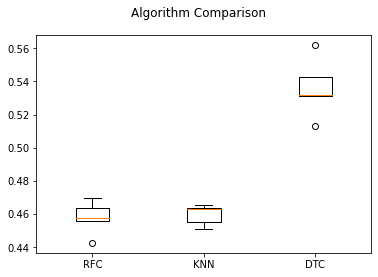

In [122]:
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

## Decision Tree worked best by far

In [123]:
model =  DecisionTreeClassifier(max_depth = 2)

In [124]:
model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=2)

In [127]:
model.score(X_train, y_train)

0.5397029578537264

In [128]:
model.score(X_test, y_test)

0.5400652043735723

## These scores are not great.

In [129]:
prediction=model.predict(X_test)

/Users/tshields/opt/anaconda3/envs/Springboard/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='issue_reported', ylabel='Density'>

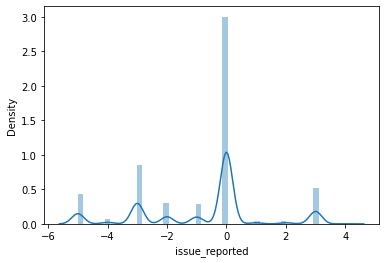

In [130]:
sns.distplot(y_test-prediction)

In [131]:
model.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 2,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

In [136]:
from sklearn.model_selection import GridSearchCV

In [137]:
param_dict = {
    'criterion': 'gini',
     'max_depth': 2,
     'min_samples_leaf': 1,
}

In [139]:
grid = GridSearchCV(model,
                    param_grid=param_dict,
                    cv=5,
                    verbose=1,
                    n_jobs=-1            
                    )
grid.fit(X_train, y_train)

ValueError: Parameter grid for parameter (criterion) needs to be a list or numpy array, but got (<class 'str'>). Single values need to be wrapped in a list with one element.